---
title: 05 - mouse classifier
author: Martin Proks
date: 14-01-2024
---

In this notebook we test what happens if we go beyond the preimplantation development and how does the scANVI deal with the annotation

In [1]:
!which pip

/projects/dan1/data/Brickman/conda/envs/scvi-1.0.0/bin/pip


In [2]:
%matplotlib inline

import scvi
import pandas as pd
import numpy as np
import seaborn as sns
import scanpy as sc
import matplotlib.pyplot as plt

from typing import Tuple

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
warnings.simplefilter('ignore', category=FutureWarning)
warnings.simplefilter('ignore', category=UserWarning)

scvi.settings.seed = 0

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

/projects/dan1/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/projects/dan1/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
[rank: 0] Global seed set to 0


In [3]:
lvae = scvi.model.SCANVI.load("../results/02_mouse_integration/scanvi_ns_15/")

INFO     File ../results/02_mouse_integration/scanvi_ns_15/model.pt already downloaded                             


## Nowotschin et al., until E6.5

In [15]:
query = sc.read("../data/external/Nowotschin_et_al_2019/sc_endoderm_all_cells.h5ad")
query.var_names = query.var_names.str.lower()
meta = pd.read_csv("../data/external/Nowotschin_et_al_2019/e35_cell_types.csv", index_col=0)

In [16]:
query = query[query.obs.Timepoint.isin(['E3.5', 'E4.5', 'E5.5', 'E6.5'])].copy()
query.obs.CellType = query.obs.CellType.astype(str)
query.obs.loc[meta.index, 'CellType'] = meta.CellType

In [17]:
query.obs['experiment'] = 'Nowotschin et al., 2019'
query.layers['counts'] = query.X
query.obs['batch'] = query.obs.Timepoint
# query.obs['ct'] = query.obs[['Timepoint', 'CellType']].agg('-'.join, axis=1)

## Query

If going beyond annotation, it will throw an error

If we set `query.obs['ct'] = query.obs[['Timepoint', 'CellType']].agg('-'.join, axis=1)` we get an error

```python
ValueError: Category E5.5-EPI not found in source registry. Cannot transfer setup without `extend_categories = True`.
```

Ref: https://discourse.scverse.org/t/dont-extend-labels-for-query-data/1196/2

In [18]:
scvi.model.SCVI.prepare_query_anndata(query, lvae)
lvae_q = scvi.model.SCANVI.load_query_data(query, lvae)
lvae_q.train(
    max_epochs=100,
    plan_kwargs=dict(weight_decay=0.0),
    check_val_every_n_epoch=10,
    # early_stopping=True
)

query.obsm["X_scANVI"] = lvae_q.get_latent_representation()
query.obs["predictions"] = lvae_q.predict()
query.obs['entropy'] = 1 - lvae_q.predict(soft=True).max(axis=1)

INFO     Found 77.63333333333333% reference vars in query data.                                                    
INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Epoch 100/100: 100%|███████████████████████████████████████████████████| 100/100 [05:35<00:00,  3.38s/it, v_num=1, train_loss_step=1.55e+3, train_loss_epoch=1.58e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|███████████████████████████████████████████████████| 100/100 [05:35<00:00,  3.36s/it, v_num=1, train_loss_step=1.55e+3, train_loss_epoch=1.58e+3]


In [20]:
query.obs['orig'] = query.obs[['Timepoint', 'CellType']].agg('-'.join, axis=1)

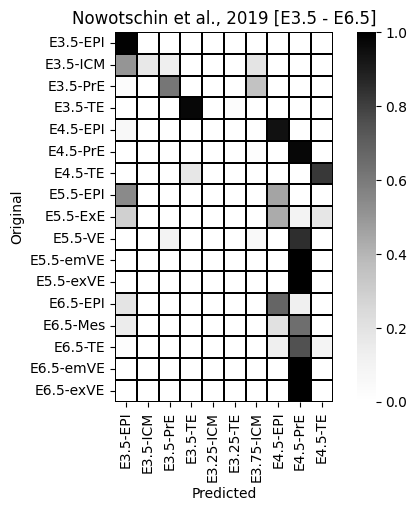

In [61]:
_ = sns.heatmap(sc.metrics.confusion_matrix('orig', 'predictions', data=query.obs), cmap='Greys', square=True, linewidth=0.2, linecolor='black').set(ylabel='Original', xlabel='Predicted', title='Nowotschin et al., 2019 [E3.5 - E6.5]')